In [0]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/trades.csv         
  inflating: data/execs.csv          
  inflating: data/quotes.csv         


In [0]:
!cp -rf images/* /dbfs/FileStore/images

In [0]:
%pip install pykx memory-profiler tabulate
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Enable PyKX Pandas API
import os

os.environ["PYKX_ENABLE_PANDAS_API"] = "true"

# kc.lic License File Location
os.environ["QLIC"] = "/Workspace/Users/username/license/"

# Ignore Warnings
import warnings

warnings.filterwarnings("ignore")

# Transaction Cost Analysis with PyKX

This course uses the Python package PyKX and builds upon knowledge presented in the `Intro To PyKX` course that we have available.
If you have not already completed this course, we recommend that you do so.
You can find it at the following link: https://kx.com/academy/courses/introduction-python-interface/.

This notebook walks through the implementation of a classic finance workflow using [PyKX](https://code.kx.com/pykx/). You will be working through a typical task performed by Stock Brokers called [Transaction Cost Analysis (TCA)](#https://en.wikipedia.org/wiki/Transaction_cost_analysis).

To make this notebook easier to digest, it is divided into 6 sections:

    1. Setup
    2. Understanding TCA
    3. Reading In The Data
    4. Exploring The Data
    5. Performing Transaction Cost Analysis
    6. Comparing Pandas Vs PyKX


The first 5 of these sections will run through how you might use PyKX to perform TCA and to show off some of the unique capabilities of PyKX.

Section 6 compares the relative performance of PyKX and Pandas at carrying out this TCA task.
Pandas is generally seen as a "must-use" tool in the Python data science toolkit and is designed specifically for data manipulation and analysis, so it is an ideal benchmark for this comparison.

From this comparison, you will see that PyKX is ~85 times faster than Pandas:

![alt text](/files/images/time.png)

And that PyKX's memory footprint is ~620 times less than that of Pandas:

![alt text](/files/images/memory.png)

# ------------------------------------------------------------------------------------------
# 1. Setup

### Import packages

In [0]:
import pykx as kx

import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

%load_ext memory_profiler

### Load helper functions

In [0]:
%load_ext autoreload
%autoreload 1

%aimport demo_functions
import demo_functions as d_funcs

### Set console size

Here we configure the output display size by setting:
 - the maximum amount of rows to output to the console
 - the maximum characters to display per row

In [0]:
kx.q.system.display_size = [50, 300]

# ------------------------------------------------------------------------------------------
# 2. Understanding TCA

### What is Transaction Cost Analysis (TCA)?

TCA is a framework used to analyse and break down the costs associated with buying or selling a financial asset.

It helping us to understand:
- how much it costs to make a trade,
- how that cost compares to the market average.

##### Amazon Example

For example, when you buy something on Amazon, the price you pay is made up of:
- the cost of the product itself,
- shipping,
- maybe some handling fees.

<img src="/files/images/amazon_example.png" width="900"/>

##### Stock Example

TCA works in a similar way, to help break down the cost of a stock into:
- the benchmark price of the stock
- slippage (which we will discuss more about later)
- broker fees & commissions

<img src="/files/images/stock_example.png" width="900"/>

### Why is TCA useful for brokers?

From a brokers perspective, TCA:
- helps to demonstrate a regulatory commitment to executing at the best price for clients,
- provides transparency to clients on trading costs, helping them to optimise their trading strategies.

# ------------------------------------------------------------------------------------------
# 3. Reading In The Data

To perform these calculations, brokers generally have access to 3 different data sets - quote data, trade data, and execution data.

Here, we will read each of these datasets into pykx tables using the [`kx.q.read.csv`](https://code.kx.com/pykx/api/read.html) function.
This function enables us to supply a `types` argument which allows us to specify the underlying [q datatypes](https://code.kx.com/q/basics/datatypes/) we want each of the columns being read in to be.

Alternatively, reading in the tables could also be done without specifying the `types` argument, whereby, the underlying types will be inferred automatically. In this case, if the inferred types was not the type you wanted, the [`astype`](https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html#tableastype) function could be applied to the table to convert the types of specific columns to their desired [PyKX types](https://code.kx.com/pykx/1.6/api/wrappers.html).

### Read into Pykx tables

##### Quotes

The first dataset we're going to read in is the quote data.
This gives us a list of the prices that market participants are willing to buy or sell the stock at, given by the bid and ask prices.

In [0]:
pykx_quotes = kx.q.read.csv("data/quotes.csv", types="DSTFFJJSS")
d_funcs.count_records_and_print(pykx_quotes)

Num Records: 7,246,329


,date,sym,time,bid,ask,bsize,asize,mode,ex
,,,,,,,,,
0,2022.03.31,MQC,04:00:00.005,133.3,260f,1,1,R,K
1,2022.03.31,MQC,04:00:00.005,223.05,260f,4,1,R,K
2,2022.03.31,MQC,04:00:00.005,234f,260f,1,1,R,K
3,2022.03.31,MQC,04:00:00.005,234f,253.39,1,3,R,K
4,2022.03.31,BKR,04:00:00.006,92.62,94.47,6,1,R,P


##### Trades

We'll also read in some trade data.
This gives us a list of trades which took place in the market, but not on our brokerage platform.

In [0]:
pykx_trades = kx.q.read.csv("data/trades.csv", types="DSTFJBBS")
d_funcs.count_records_and_print(pykx_trades)

Num Records: 897,207


,date,sym,time,price,size,stop,cond,ex
,,,,,,,,
0,2022.03.31,BKR,04:00:00.003,93.21,5,0b,1b,P
1,2022.03.31,TOUR,04:00:00.003,515.45,1,0b,1b,P
2,2022.03.31,F.PRA,04:01:50.721,333.99,3,0b,0b,K
3,2022.03.31,F.PRA,04:04:57.713,332.6,1,0b,1b,P
4,2022.03.31,AEF,04:06:29.248,617f,2,0b,1b,P


##### Executions

The final dataset needed is execution data.
This is a list of the trades which took place on our platform which we, as the broker, executed against for our clients.

In [0]:
pykx_execs = kx.q.read.csv("data/execs.csv", types="DSTFJSS")
d_funcs.count_records_and_print(pykx_execs)

Num Records: 20,458


,date,sym,time,price,size,side,venue
,,,,,,,
0,2022.03.31,GE.PRA,09:30:02.676,397.6131,12,BUY,venue1
1,2022.03.31,MQC,09:30:02.851,254.8359,258,SELL,venue3
2,2022.03.31,BKR,09:30:03.426,93.64192,154,BUY,venue2
3,2022.03.31,GE.PRA,09:30:04.489,397.5469,12,SELL,venue2
4,2022.03.31,DXGE,09:30:06.677,570.1041,60,SELL,venue3


##### Sort the tables on time

We can sort these tables based on the `time` column using pykx's [`kx.q.xasc`](https://code.kx.com/pykx/api/q/q.html#xasc) function.
This will apply a [sorted attribute](https://code.kx.com/q/ref/set-attribute/#sorted) to the `time` column in the table behind the scenes.
This attribute will help to improve the time and memory performance of our queries when querying these tables on the `time` column.

In [0]:
pykx_quotes = kx.q.xasc("time", pykx_quotes)
pykx_trades = kx.q.xasc("time", pykx_trades)
pykx_execs = kx.q.xasc("time", pykx_execs)

##### Group the sym column in the tables

We can also add a [grouped attribute](https://code.kx.com/q/ref/set-attribute/#grouped-and-parted) to the `sym` column in the table. This is done by updating the `sym` column in the table using the [`kx.q.qsql.update`](https://code.kx.com/pykx/api/query.html#pykx.query.QSQL.update) function so that it becomes a grouped `sym` column.
This will help to improve the time and memory performance of our queries when querying these tables on the `sym` column.

In [0]:
pykx_quotes = kx.q.qsql.update(pykx_quotes, {"sym": "`g#sym"})
pykx_trades = kx.q.qsql.update(pykx_trades, {"sym": "`g#sym"})
pykx_execs = kx.q.qsql.update(pykx_execs, {"sym": "`g#sym"})

# ------------------------------------------------------------------------------------------
# 4. Exploring The Data

Before performing the transaction cost analysis itself, it is useful to perform some initial analysis of the the data so we have an idea of the general trends and patterns in it.
We will revolve this analysis around the slippage factor mentioned previously as this is the main value that we are trying to uncover when carrying out TCA.

Slippage is the difference between the price a stock is bought or sold at and a pre-determined benchmark price.

    Slippage = ExecutionPrice - BenchmarkPrice

This value will vary from stock to stock and fluctuates extremely frequently based on a number of factors. These can be broken down as follows:

<img src="/files/images/slippage_breakdown.png" width="900"/>

For a deeper dive into this, we will focus on the first 3 factors from the above image and try to visualise them over the course of a trading day for the first 2 stocks in our dataset.

We can get a list of the distinct symbols using the [`kx.q.distinct`](https://code.kx.com/pykx/api/q/q.html#distinct) function and choose the first two of these.

In [0]:
unique_syms = sorted(kx.q.distinct(pykx_quotes["sym"]).py())
len(unique_syms)

26

In [0]:
plot_syms = unique_syms[:2]
plot_syms

['AEF', 'AGND']

### Define Analysis Functions

The way that this analysis will be performed is that, for each of the 3 slippage factors we want to analyse, we will define a generic python function which will calculate this metric based on input stock data.
Once this is done, we will then call these python functions, iteratively passing in the stock data for each of the two stocks we want to analyse.

The first step is defining a function for Volatility, Spread, and Liquidity.

##### Calculate Volatility Using pandas API

<img src="/files/images/volatility.png"/>

Despite pykx being a python package, pykx works in the q memory space so you can use it to call q functions.

This functionality may be used to call q functions which are defined in files on disk, however, here, for transparency, we will define this functions within the notebook.

Using q via PyKX's [`kx.q`](https://code.kx.com/pykx/api/embedded_q.html) function, we can create a function called `get_volatility`, which will return the volatility of a stock based on it's bid and ask prices.

In [0]:
kx.q("get_volatility: {[bid;ask] {r:0^log[x]-log next x;sqrt ema[0.001] r*r } 0.5*ask+bid};")

pykx.Identity(pykx.q('::'))

This `get_volatility` q function can then be accessed using the same [`kx.q`](https://code.kx.com/pykx/api/embedded_q.html) function that was used to create it.
This can be seen below in the return statement of the volatility calculation where we pass the bid and ask columns into this function.

The syntax for indexing Pandas dataframes is also supported on PyKX tables.
This allows us to select a subset of the rows from the PyKX table based on:
   - the specific symbols we are looking for,
   - the time range being within the trading day of 9:30am to 4pm.

In [0]:
def get_volatility(quotes, sym) -> dict:
    subset_quotes = pykx_quotes.loc[
        (pykx_quotes["sym"] == sym)
        & (pykx_quotes["time"] > timedelta(hours=9, minutes=25))
        & (pykx_quotes["time"] < timedelta(hours=16, minutes=5))
    ]
    return {
        "datetime": subset_quotes["date"] + subset_quotes["time"],
        "volatility": kx.q("get_volatility", subset_quotes["bid"], subset_quotes["ask"]),
    }

##### Calculate Spreads Using qsql API

<img src="/files/images/spread.png"/>

We can also define and use python functions with PyKX.

Here, we define a python function to calculate a moving average over a spread vector, where the spread is the ask price minus the bid price.
Numpy's [`np.convolve`](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) function can then be used for creating the moving average vector from this spread vector.

This helper function can then be called in our main spread function.

In [0]:
def get_mavg_of_spread(bid, ask, mavg_size: int):
    spreads = ask - bid
    return np.convolve(spreads, np.ones(mavg_size), mode="same") / mavg_size

PyKX supports many different ways of indexing tables and manipulating them.
As shown above, the Pandas API is one of these ways.
Another way of extracting a subset of the data from the PyKX table is using the [qsql select query API](https://code.kx.com/pykx/api/query.html#pykx.query.QSQL.select).

This API has a q backend but uses a python like syntax for retrieving data from pykx tables. It takes:
- the table we want to select from,
- a dictionary defining what our resulting columns should be,
- a list of conditions for the where clause.

As the underlying language to this syntax is q, we must expose the above defined function to the q memory space, using PyKX to convert our python helper function into a q function.
This allows us to use the function as a normal q function, supplying it with a bid, ask, and moving average value.

In [0]:
kx.q["mavg_of_spread"] = get_mavg_of_spread

In [0]:
def get_spread(quotes: kx.Table, sym: str) -> kx.Table:
    return kx.q.qsql.select(
        quotes,
        columns={"datetime": "date+time", "spread": "mavg_of_spread[bid; ask; 1000]"},
        where=[f"sym=`{sym}", "time within (09:25;16:05)"],
    )

##### Calculate Trading Volume Using SQL API

<img src="/files/images/liquidity.png"/>

For a liquidity calculation, we will actually focus on trading volume as there is a strong correlation between these two.

    Trading Volume = NumSharesTraded * SharePrice

Trading volume is usually calculated in time buckets in order to get a sense of it's value over time, so that it is not skewed by any one transaction.

As such, here, we will calculate the trading volume for the given stock over each 10 minute window during the trading day.

This can be done through PyKX's [SQL API](https://code.kx.com/pykx/api/query.html#pykx.query.SQL) using pure SQL code to query the PyKX table.

In [0]:
def get_trading_volume(trades, sym) -> kx.Table:
    return kx.q.sql(
        """
        SELECT date+bucket AS interval, SUM(price*size) AS volume
        FROM (SELECT CAST(SUBSTRING(time, 1, 4)||'0' AS TIME) AS bucket, date, price, size, sym FROM $1)
        WHERE sym=$2
              AND bucket >= CAST('09:30' as time)
              AND bucket < CAST('16:00' as time)
        GROUP BY bucket
        """,
        pykx_trades,
        sym,
    )

### Analyse Spreads, Predicted Volatility, and Trading Volume

Now we can iteratively call each of these functions to calculate their values for our 2 stock symbols and visualise these results.
This can be done seamlessly and in an identical way to how somebody might do this using Pandas.

The functions run to create the plots can be found in the `demo_functions.py` file in the same directory as this notebook.

NOTE: This cell takes ~8 seconds to run as the resulting plots have to be rendered.

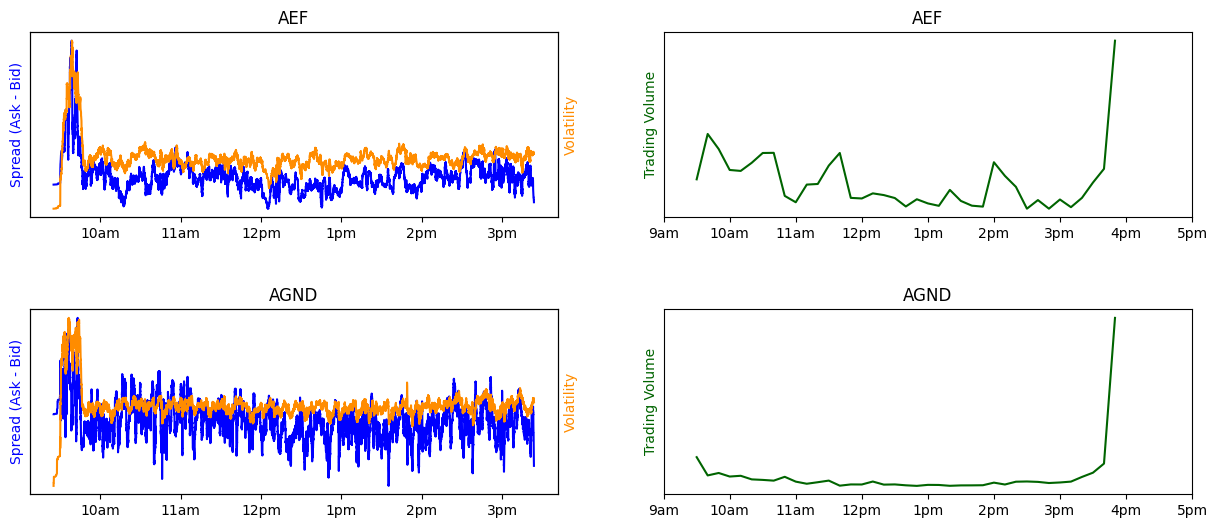

In [0]:
fig, ax = plt.subplots(figsize=(15, 3 * len(plot_syms)), ncols=2, nrows=len(plot_syms))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, sym in enumerate(plot_syms):

    spread_tab = get_spread(pykx_quotes, sym)
    volatility_dict = get_volatility(pykx_quotes, sym)
    trad_vol_tab = get_trading_volume(pykx_trades, sym)

    d_funcs.plot_spreads_volatility_and_trade_volume(
        ax, sym, i, spread_tab, volatility_dict, trad_vol_tab
    )

plt.show()

In [0]:
get_spread(pykx_quotes, plot_syms[0])

,datetime,spread
,,
0,2022.03.31D09:25:03.491000000,10.76097
1,2022.03.31D09:25:46.166000000,10.77096
2,2022.03.31D09:27:01.015000000,10.78095
3,2022.03.31D09:27:10.556000000,10.79095
4,2022.03.31D09:27:10.557000000,10.80094
5,2022.03.31D09:27:36.596000000,10.81093
6,2022.03.31D09:27:36.596000000,10.82092
7,2022.03.31D09:27:40.324000000,10.83091
8,2022.03.31D09:27:40.340000000,10.8409


In [0]:
get_volatility(pykx_quotes, plot_syms[0])

{'datetime': pykx.TimestampVector(pykx.q('2022.03.31D09:25:03.491000000 2022.03.31D09:25:46.166000000 2022.03.31D09:27:01.015000000 2022.03.31D09:27:10.556000000 2022.03.31D09:27:10.557000000 2022.03.31D09:27:36.596000000 2022.03.31D09:27:36.596000000 2022.03.31D09:27:40.324000000 2022.03.31D09:27:40.340000000 2022.03.31D09:27:57.3040000..')),
 'volatility': pykx.FloatVector(pykx.q('0.003473635 0.003496871 0.003534634 0.003532866 0.003612577 0.003686721 0.003689011 0.003687166 0.003688629 0.00369009 0.003688245 0.003686691 0.003684847 0.003684642 0.003682799 0.003731983 0.003734018 0.003810196 0.00380829 0.003879471 0.0039493 0.004012355 0.004074374 0.004072382 0.004070896 0..'))}

In [0]:
get_trading_volume(pykx_trades, plot_syms[0])

,interval,volume
,,
0,2022.03.31D09:30:00.000000000,2.197469e+07
1,2022.03.31D09:40:00.000000000,4.394176e+07
2,2022.03.31D09:50:00.000000000,3.664388e+07
3,2022.03.31D10:00:00.000000000,2.65078e+07
4,2022.03.31D10:10:00.000000000,2.60495e+07
5,2022.03.31D10:20:00.000000000,2.998326e+07
6,2022.03.31D10:30:00.000000000,3.473124e+07
7,2022.03.31D10:40:00.000000000,3.480725e+07
8,2022.03.31D10:50:00.000000000,1.395849e+07


##### Plot Analysis

We can see that on the LHS, as the volatility increases, the spread also increases.

This LHS plot also tells us that the volatility and spread are greater at both the open and close of the day.

This corrolates well with the trading volume plot on the RHS, where we can see that there is more trading volume at day open and close.

Generally, at the end of the day, traders will minimise their market exposure so that they are not at risk to big market moves overnight.
This results in a lot of buying and selling and hence, more volatility.

# ------------------------------------------------------------------------------------------
# 5. Performing Transaction Cost Analysis

Now that we have a better idea of what makes up this slippage value and how it is effected based on it's various factors, we can calculate the transaction cost for clients using the PyKX tables we have read in.

As this slippage factor is measured as the execution price minus the benchmark price, the chosen benchmark price is pivotal to the overall results derived.

### What are the common benchmark prices?

There are many ways to choose a benchmark price. Some common choices include:
- a moving average of the last traded prices
- the midpoint between the latest quoted bid and ask prices (arrival mid price)
- the last traded price

In this example, we will use the arrival mid price as our benchmark price.

<img src="/files/images/arrival_mid_and_slippage.png" width="900"/>

### Compare Executed Price To Mid Quoted Price

The first step in this analysis is to join the quotes and execution tables together so that we can accurately compare the quoted bid and ask prices with the execution prices.

This is done using what's called an *asof join* - where we join the quotes to the executions, taking the latest quote data as of the execution time.

So if my execution occurred at 2pm and there was a quote at 1:58, 1:59, and 2:01, we would match my 2pm execution with the quote that occurred at 1:59.

<img src="/files/images/aj.png" width="900"/>

We can join the tables here using PyKX's [`kx.q.aj`](https://code.kx.com/pykx/api/q/q.html#aj) function, joining on the `sym` and `time` columns in both tables.

In [0]:
merged = kx.q.aj(kx.SymbolVector(["sym", "time"]), pykx_execs, pykx_quotes)

Once the tables are joined, we can compute:
- the arrival mid prices,
- the difference between the arrival mid and the executed price,
- the resulting slippage, measured in basis points.

In [0]:
merged["mid"] = 0.5 * (merged["bid"] + merged["ask"])
merged["diff"] = np.where(
    merged["side"] == "BUY", merged["mid"] - merged["price"], merged["price"] - merged["mid"]
)
merged["slippage"] = (merged["diff"] / merged["mid"]) * 10000

The resulting pykx table will look as follows, where we have:
- identifier columns ----------- (date, sym, time)
- the execution data ---------- (price, size, side, venue)
- the quote data --------------- (bid, ask, bsize, asksize, mode, ex)
- the 3 additional columns -- (mid, diff, slippage)

In [0]:
merged.head(10)

,date,sym,time,price,size,side,venue,bid,ask,bsize,asize,mode,ex,mid,diff,slippage
,,,,,,,,,,,,,,,,
0,2022.03.31,GE.PRA,09:30:02.676,397.6131,12,BUY,venue1,396.51,397.96,1,1,R,N,397.235,-0.3781,-9.518295
1,2022.03.31,MQC,09:30:02.851,254.8359,258,SELL,venue3,254.32,254.99,2,1,R,V,254.655,0.1809,7.103729
2,2022.03.31,BKR,09:30:03.426,93.64192,154,BUY,venue2,93.64,93.72,1,1,R,N,93.68,0.03808,4.064902
3,2022.03.31,GE.PRA,09:30:04.489,397.5469,12,SELL,venue2,397.21,398.8,1,2,R,T,398.005,-0.4581,-11.50991
4,2022.03.31,DXGE,09:30:06.677,570.1041,60,SELL,venue3,569.08,571.34,2,3,R,P,570.21,-0.1059,-1.857211
5,2022.03.31,AXJL,09:30:08.354,500.0938,89,SELL,venue3,499.15,500.93,1,2,R,T,500.04,0.0538,1.075914
6,2022.03.31,DXGE,09:30:08.896,570.3715,81,BUY,venue2,569.17,571.34,2,1,R,P,570.255,-0.1165,-2.042946
7,2022.03.31,GE.PRA,09:30:08.945,397.3688,181,BUY,venue3,397.11,398.25,2,4,R,N,397.68,0.3112,7.825387
8,2022.03.31,AXJL,09:30:09.139,500.1021,38,BUY,venue3,499.15,500.93,2,1,R,V,500.04,-0.0621,-1.241901


As part of this analysis, a broker may want to compare the venues which they executed their trades against to see which venue had a lower slippage, and hence gave a better price for their clients.
If a broker can ensure they execute trades on the venue which is most favourable for their clients, this enables that client to get a cheaper price and hence make them happier to trade with the broker.

Using a function defined in the `demo_functions.py` file contained alongside this notebook, we can graph the slippage for each of the venues in the dataset by volume and check how the slippage for each venue fares relative to one another.

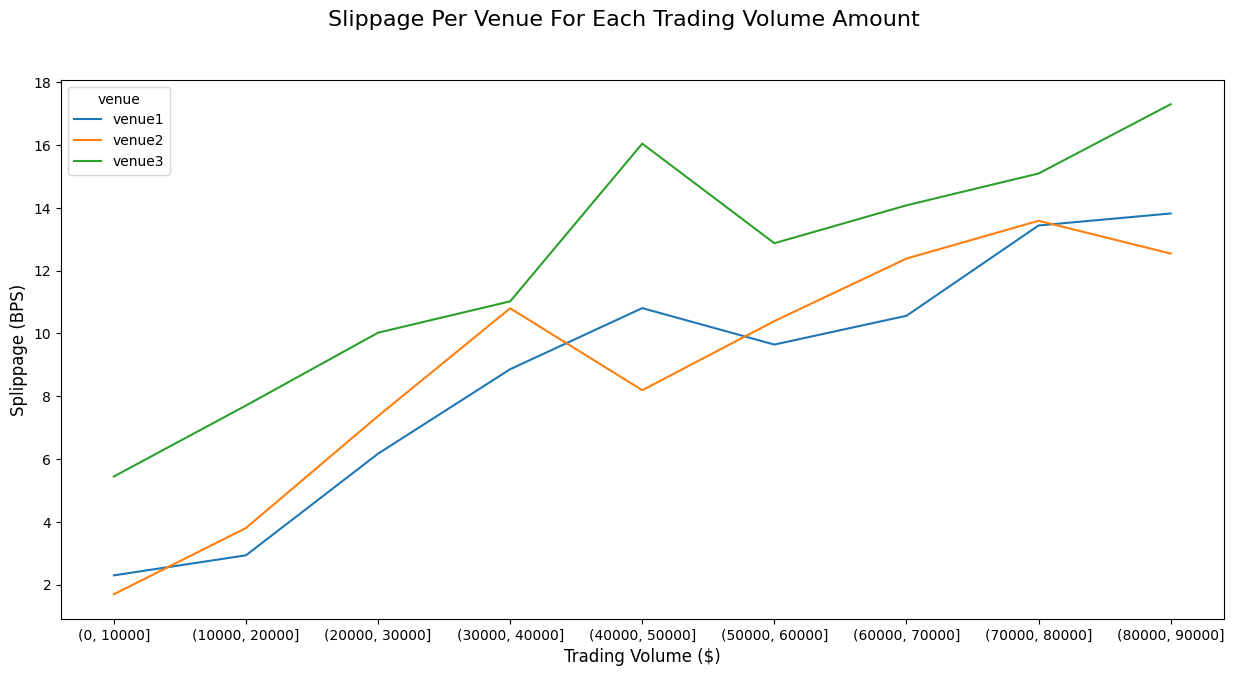

In [0]:
d_funcs.plot_slippage(merged.pd())

The resulting graph paints us a clear picture that the slippage is lower for venue 1 and 2, when compared with venue 3.

This analysis might allow us to make better dicisions on which venues we execute our trades against to get the best price for our clients.
If we were a broker, in this case, we might choose to avoid executing trades on venue3 and just use venue 1 and 2.

# ------------------------------------------------------------------------------------------
# 6. Comparing PyKX Vs Pandas

This section contains a comparison of PyKX and Pandas in terms of speed and memory footprint.

Both packages will perform the same TCA calculations there we run in the above sections, with the time taken and memory used for each being recorded.

### Define Pandas dataframes

We have already read the data into PyKX tables, but, we need to define Pandas dataframes of the same data so we can use this for the comparison.

This conversion can easily be done using PyKX's [`.pd()`](https://code.kx.com/pykx/1.4/api/wrappers.html#pykx.wrappers.List.np) method to turn the PyKX table into a Pandas dataframe.

In [0]:
quotes_df = pykx_quotes.pd()
trades_df = pykx_trades.pd()
execs_df = pykx_execs.pd()

### Run TCA in both PyKX and Pandas

We can now run these exact same calculations in both pykx and pandas, capturing both the memory and time taken for these calculations to be performed in each.
The time is recorded using the built in [`%%timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) magic command.
The memory is recorded using the `%%memit` magic command built into the [memory profiler](https://pypi.org/project/memory-profiler/) package.

These metrics are stored into variables using the [`%%capture`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-capture) magic command.
This allows for easy comparison once all the time and memory results have been captured.

##### PyKX

In [0]:
d_funcs.collect_garbage()

In [0]:
%%capture pykx_mem_res
%%memit -i 0.01

# merge tables
pykx_merged = kx.q.aj(kx.SymbolVector(["sym", "time"]), pykx_execs, pykx_quotes)

# define 3 new columns
pykx_merged["mid"] = 0.5 * (pykx_merged["bid"] + pykx_merged["ask"])
pykx_merged["diff"] = np.where(
    pykx_merged["side"] == "BUY",
    pykx_merged["mid"] - pykx_merged["price"],
    pykx_merged["price"] - pykx_merged["mid"],
)
pykx_merged["slippage"] = (pykx_merged["diff"] / pykx_merged["mid"]) * 10000

In [0]:
d_funcs.collect_garbage()

In [0]:
%%capture pykx_time_res
%%timeit

# merge tables
pykx_merged = kx.q.aj(kx.SymbolVector(["sym", "time"]), pykx_execs, pykx_quotes)

# define 3 new columns
pykx_merged["mid"] = 0.5 * (pykx_merged["bid"] + pykx_merged["ask"])
pykx_merged["diff"] = np.where(
    pykx_merged["side"] == "BUY",
    pykx_merged["mid"] - pykx_merged["price"],
    pykx_merged["price"] - pykx_merged["mid"],
)
pykx_merged["slippage"] = (pykx_merged["diff"] / pykx_merged["mid"]) * 10000

##### Pandas

In [0]:
d_funcs.collect_garbage()

In [0]:
%%capture pandas_mem_res
%%memit -i 0.01

# merge tables
python_merged = pd.merge_asof(execs_df, quotes_df, on="time", by="sym")

# define 3 new columns
python_merged["mid"] = 0.5 * (python_merged["bid"] + python_merged["ask"])
python_merged["diff"] = np.where(
    python_merged["side"] == "BUY",
    python_merged["mid"] - python_merged["price"],
    python_merged["price"] - python_merged["mid"],
)
python_merged["slippage"] = (python_merged["diff"] / python_merged["mid"]) * 10000

In [0]:
d_funcs.collect_garbage()

In [0]:
%%capture pandas_time_res
%%timeit

# merge tables
python_merged = pd.merge_asof(execs_df, quotes_df, on="time", by="sym")

# define 3 new columns
python_merged["mid"] = 0.5 * (python_merged["bid"] + python_merged["ask"])
python_merged["diff"] = np.where(
    python_merged["side"] == "BUY",
    python_merged["mid"] - python_merged["price"],
    python_merged["price"] - python_merged["mid"],
)
python_merged["slippage"] = (python_merged["diff"] / python_merged["mid"]) * 10000

##### Define results

In [0]:
time_res_df, mem_res_df = d_funcs.parse_vals(
    pandas_time_res, pykx_time_res, pandas_mem_res, pykx_mem_res
)

### Visualise Results

To get a sense of how these PyKX and Pandas compare, it is useful to show their relative performance alongside one another.

Using a number of helper functions defined in the `demo_functions.py` file that comes alongside this notebook, we can easily show the numeric values associated with each and also a visualisation of this.

##### Visualise Speed Improvements

+----+----------+------------+-----------+--------+---------+
|    | syntax   | avg_time   | avg_dev   |   runs |   loops |
|----+----------+------------+-----------+--------+---------|
|  0 | Pandas   | 2.06 s     | 26.3 ms   |      7 |       1 |
|  1 | PyKX     | 18.1 ms    | 1.54 ms   |      7 |      10 |
+----+----------+------------+-----------+--------+---------+

The 'avg_time' for 'PyKX' is 113.81 times less than 'Pandas'.



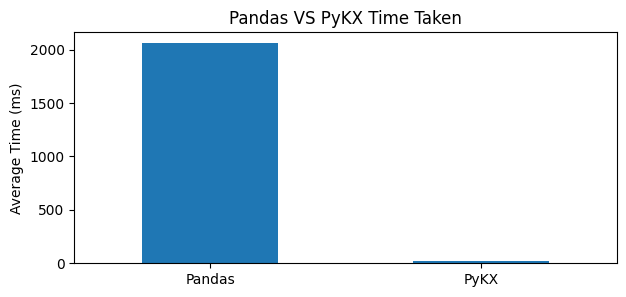

In [0]:
numeric_time_res_df = d_funcs.graph_time_data(time_res_df)

When we visualise the time related results, we can see there is a massive speedup between pandas and pykx, with pykx being ~85 times faster than pandas at performing this calculation.

Pykx leverages the underlying power of q to perform these operations, allowing Python developers to take advantage of the optimisations inherent to q when dealing with large datasets.

##### Visualise Memory Improvments

+----+----------+----------------+--------------------+
|    | syntax   | total_memory   | memory_increment   |
|----+----------+----------------+--------------------|
|  0 | Pandas   | 2628.29 MiB    | 884.55 MiB         |
|  1 | PyKX     | 1743.41 MiB    | 1.62 MiB           |
+----+----------+----------------+--------------------+

The 'memory_increment' for 'PyKX' is 546.02 times less than 'Pandas'.



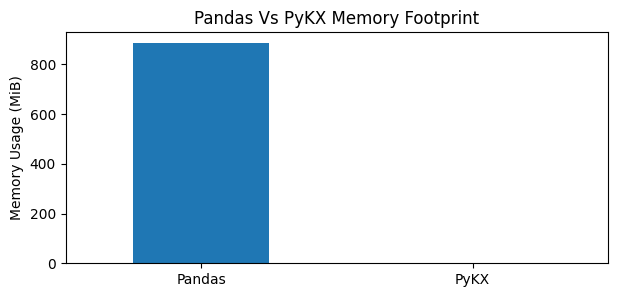

In [0]:
numeric_mem_res_df = d_funcs.graph_memory_data(mem_res_df)

We can also visualise the memory footprint of running these calculations in both pandas and pykx.

Here again, pykx comes out on top, showing a similarly massive decrease in the memory usage.

This shows the extreme efficiency of q for both memory and speed.